Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

Data import

In [2]:
train = pd.read_csv("data/training.csv")
test = pd.read_csv("data/test.csv")




In [3]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

    # f1_scores = cross_val_score(XGBRegressor(), X, y, scoring="f1", cv=5)
    # f1_scores = pd.Series(f1_scores, name="F1 Scores")

Exploring dataSet

In [4]:

# train.select_dtypes(["object"]).nunique()
train.head(5)
# test.select_dtypes(["object"]).nunique()
# test.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [5]:
train.nunique()
# test.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

Feature encoding and engineering

In [6]:
train = train.sample(frac=1).reset_index(drop=True)
train_Y = train.FraudResult
train.drop(['FraudResult'], axis=1, inplace=True)



features = ["BatchId","AccountId","SubscriptionId","CustomerId","ProviderId","ProductId","ProductCategory","ChannelId","Amount","Value","TransactionStartTime","PricingStrategy"]

# train.drop(['CurrencyCode','CountryCode'], axis=1, inplace=True)
# test.drop(['CurrencyCode','CountryCode'], axis=1, inplace=True)


In [7]:
def getDay(x):
    return float(''.join(x.split("T")[0].split("-")))

def getTime(x):
    time = x.split("T")[1].split(":")
    time[-1] = time[-1][:-1]
    return float(''.join(time))

In [8]:
StringToClean = ["TransactionId", "BatchId","AccountId","SubscriptionId","CustomerId", "ProviderId", "ProductId", "ChannelId", "ProductCategory"]

# train[StringToClean].apply()

first_data = train.copy()
for col in StringToClean:
    first_data[col] = first_data[col].apply(lambda x : x.split("_")[-1])

first_data["TransactionStartDay"]  = first_data["TransactionStartTime"].apply(getDay)
first_data["TransactionStartTime"] = first_data["TransactionStartTime"].apply(getTime)
first_data = first_data.set_index("TransactionId")
first_data.drop(['CurrencyCode'], axis=1, inplace=True)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(first_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)

# One-hot encoding removed index; put it back
OH_cols_train.index = first_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = first_data.drop(["ProductCategory"], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)


OH_X_train.head()
# OH_X_train["TransactionStartTime"].head()
train_clean = OH_X_train.copy()

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


creating different models


In [9]:
decisionTree = DecisionTreeClassifier()

randomForest = RandomForestClassifier()

multiLayerPerceptron = MLPClassifier(activation='tanh')

# decisionTree.fit(OH_X_train, train_Y)

# randomForest.fit(OH_X_train,train_Y)

# multiLayerPerceptron.fit(OH_X_train, train_Y)


In [10]:
f1_scores_mlp = cross_val_score(multiLayerPerceptron, OH_X_train, train_Y, scoring="f1", cv=5)
print(f1_scores_mlp)

[0. 0. 0. 0. 0.]


In [11]:
f1_scores_DT = cross_val_score(decisionTree, OH_X_train, train_Y, scoring="f1", cv=5)
print(f1_scores_DT)

[0.83544304 0.90243902 0.91358025 0.81012658 0.78481013]


In [12]:
f1_scores_rf = cross_val_score(randomForest, OH_X_train, train_Y, scoring="f1", cv=5)
print(f1_scores_rf)

[0.85714286 0.92307692 0.94871795 0.87179487 0.89473684]


In [13]:
#smote

from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()
smote_X, smote_Y = SMOTE.fit_resample(OH_X_train, train_Y)

# f1_scores_mlp = cross_val_score(multiLayerPerceptron, smote_X, smote_Y, scoring="f1", cv=5)
# print(f1_scores_mlp)

In [14]:
print(smote_Y.unique())
print(smote_Y.value_counts())
print(train_Y.value_counts())

[0 1]
0    95469
1    95469
Name: FraudResult, dtype: int64
0    95469
1      193
Name: FraudResult, dtype: int64


In [15]:
StringToClean = ["TransactionId", "BatchId","AccountId","SubscriptionId","CustomerId", "ProviderId", "ProductId", "ChannelId", "ProductCategory"]

# train[StringToClean].apply()

test_data = test.copy()
for col in StringToClean:
    test_data[col] = test_data[col].apply(lambda x : x.split("_")[-1])

test_data["TransactionStartDay"]  = test_data["TransactionStartTime"].apply(getDay)
test_data["TransactionStartTime"] = test_data["TransactionStartTime"].apply(getTime)
test_data = test_data.set_index("TransactionId")
test_data.drop(['CurrencyCode'], axis=1, inplace=True)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(test_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)

# One-hot encoding removed index; put it back
OH_cols_train.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = test_data.drop(["ProductCategory"], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)


OH_X_train.head()
# OH_X_train["TransactionStartTime"].head()

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,...,TransactionStartDay,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
TransactionId,,,,,,,,,,,,,,,,,,,,,
50600,35028,2441,4426,2857,256,5,3,3,1000.0,1000,...,20190213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95109,45139,3439,2643,3874,256,5,15,3,2000.0,2000,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47357,74887,4841,3829,2857,256,4,6,2,-50.0,50,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28185,11025,2685,4626,3105,256,5,10,3,3000.0,3000,...,20190213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22140,29804,4841,3829,3105,256,4,6,2,-60.0,60,...,20190213.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
multiLayerPerceptron.fit(smote_X, smote_Y)
test_res = multiLayerPerceptron.predict(OH_X_train)

In [17]:
decisionTree.fit(smote_X, smote_Y)
test_res = decisionTree.predict(OH_X_train)

In [18]:
randomForest.fit(smote_X, smote_Y)
test_res = randomForest.predict(OH_X_train)

In [19]:
#import xgboost
from xgboost import XGBClassifier
my_model = XGBClassifier(n_estimators=500)
#change dtype of all collumns to float
X = smote_X.astype('float32')
Y = smote_Y.astype('float32')
my_model.fit(X,Y)
test_res = my_model.predict(OH_X_train.astype('float32'))

In [20]:
a = my_model.predict(OH_X_train.astype('float32'))
b = multiLayerPerceptron.predict(OH_X_train)

print(np.unique(a, return_counts=True))
print(np.unique(b, return_counts=True))

(array([0, 1]), array([44934,    85], dtype=int64))
(array([0, 1], dtype=int64), array([45015,     4], dtype=int64))


In [21]:
print(test_res)

#concatenate the test result with coresponding transaction id
output = pd.DataFrame()
output["TransactionId"] = test["TransactionId"]
output["FraudResult"] = test_res
print(output.head(20))

#save the result to csv file
output.to_csv("submission.csv", index=False)

[0 0 0 ... 0 0 0]
           TransactionId  FraudResult
0    TransactionId_50600            0
1    TransactionId_95109            0
2    TransactionId_47357            0
3    TransactionId_28185            0
4    TransactionId_22140            0
5   TransactionId_134338            0
6   TransactionId_109096            0
7    TransactionId_14249            0
8    TransactionId_69896            0
9    TransactionId_91468            0
10   TransactionId_18862            0
11   TransactionId_29342            0
12  TransactionId_116873            0
13   TransactionId_81197            0
14   TransactionId_83120            0
15   TransactionId_40882            0
16   TransactionId_89297            0
17  TransactionId_112716            0
18   TransactionId_61794            0
19  TransactionId_124957            0


In [22]:
train_clean.head()

,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,...,TransactionStartDay,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
TransactionId,,,,,,,,,,,,,,,,,,,,,
88782,111402,3027,3197,3452,256,6,3,3,3000.0,3000,...,20181231.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72573,45684,2314,4722,2728,256,6,14,3,1500.0,1500,...,20190121.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51512,139469,4249,4429,7343,256,4,3,2,-25000.0,25000,...,20190108.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11589,61257,2013,1042,2414,256,5,15,3,20000.0,20000,...,20181207.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
54159,31171,32,3142,348,256,1,15,3,2000.0,2000,...,20181129.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
# for colname in train_clean.select_dtypes("object"):
#     train_clean[colname], _ =train_clean[colname].factorize()

train_clean.head()
train_clean.select_dtypes("object").head()

scores = make_mi_scores(train_clean, train_Y)

In [24]:
print(scores)

BatchId                 0.102120
Amount                  0.016007
Value                   0.012216
CustomerId              0.011582
SubscriptionId          0.010871
AccountId               0.009621
ProductCategory_7       0.005725
ChannelId               0.003985
ProviderId              0.003933
ProductId               0.002594
ProductCategory_4       0.001119
TransactionStartDay     0.001101
PricingStrategy         0.001080
TransactionStartTime    0.000821
ProductCategory_0       0.000170
ProductCategory_1       0.000047
ProductCategory_2       0.000000
ProductCategory_3       0.000000
ProductCategory_5       0.000000
ProductCategory_6       0.000000
CountryCode             0.000000
ProductCategory_8       0.000000
Name: MI Scores, dtype: float64


In [25]:
import math
train_clean["Sign"] = train_clean["Amount"].apply(lambda x : x>=0)
train_clean.drop(["Amount"], axis=1, inplace=True)
train_clean.drop(["CountryCode"], axis=1, inplace=True)

In [26]:
print(train_clean.dtypes)

BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
ProviderId               object
ProductId                object
ChannelId                object
Value                     int64
TransactionStartTime    float64
PricingStrategy           int64
TransactionStartDay     float64
ProductCategory_0       float64
ProductCategory_1       float64
ProductCategory_2       float64
ProductCategory_3       float64
ProductCategory_4       float64
ProductCategory_5       float64
ProductCategory_6       float64
ProductCategory_7       float64
ProductCategory_8       float64
Sign                       bool
dtype: object


In [27]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


pca, X_pca, loadings = apply_pca(train_clean.astype('float32'), standardize=True)
print(loadings)

                           PC1       PC2       PC3       PC4       PC5  \
BatchId              -0.015860 -0.157228  0.312930  0.097889 -0.047606   
AccountId            -0.377186 -0.208804  0.093702 -0.303768 -0.001312   
SubscriptionId       -0.276528 -0.165048  0.062902  0.027969  0.033992   
CustomerId           -0.072693 -0.353927  0.495878 -0.287344 -0.033361   
ProviderId            0.275614 -0.103325 -0.197120 -0.495901  0.049854   
ProductId            -0.002619  0.509901  0.433372 -0.046077 -0.017885   
ChannelId             0.413449  0.134453  0.089591  0.083772 -0.017804   
Value                 0.002021  0.078176  0.145716  0.384000 -0.087103   
TransactionStartTime -0.000934 -0.021974  0.037088 -0.182266 -0.022222   
PricingStrategy       0.081378 -0.385700  0.394987  0.315476 -0.011058   
TransactionStartDay   0.030622  0.007732  0.028777  0.098956 -0.708721   
ProductCategory_0     0.387121 -0.374869 -0.058958  0.051293 -0.008036   
ProductCategory_1     0.046881  0.2528

In [28]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

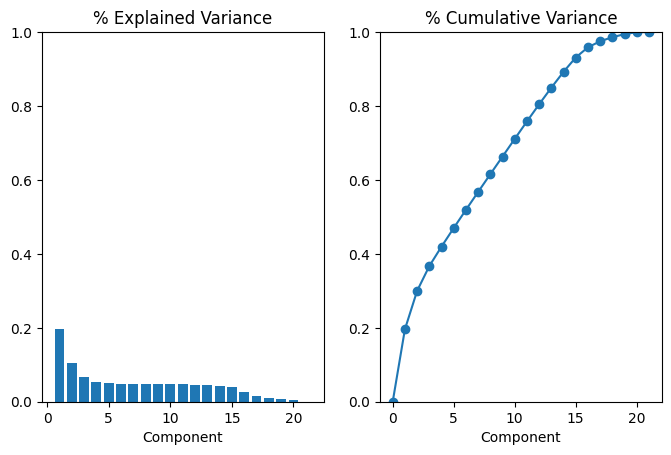

In [29]:
plot_variance(pca);